<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/09_PredictionDynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: oguiza@timeseriesAI.co

# PredictionDynamics: gain more insights during training

> Callback used to visualize model predictions during training. 

I've created this callback based on a [blog post](http://karpathy.github.io/2019/04/25/recipe/) by Andrej Karpathy I read some time ago. Some of the advice is a bit out-of-date but most of it is still very relevant. One of the things he recommended was to: 
>**visualize prediction dynamics**: I like to visualize model predictions on a fixed test batch during the course of training. The “dynamics” of how these predictions move will give you incredibly good intuition for how the training progresses. Many times it is possible to feel the network “struggle” to fit your data if it wiggles too much in some way, revealing instabilities. Very low or very high learning rates are also easily noticeable in the amount of jitter." A. Karpathy

I've used it lately, and I believe it can provide additional insights during training you don't get with the losses or metrics (that's not their goal). 

It's designed to work in **classfication, regression and forecasting tasks**. 

It's also model agnostic, meaning that you can use it with any deep learning model you want.

I encourage you to use it with your own datasets and share your findings!

# Import libraries

In [ ]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [ ]:
from tsai.all import *
my_setup()

os              : Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
python          : 3.7.15
tsai            : 0.3.5
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.12.1+cu113
device          : 1 gpu (['Tesla T4'])
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : [14.75] GB


# PredictionDynamics in classification tasks

If you want to start visualizing the model's predictions of the validation dataset during training the only thing you really need to do is to add PredictionDynamics() to your callbacks (if any). That's it! 

At the end of every epoch you will be able to see a chart that will display the predictions of the validation set. In this way you will be able to see very quickly what is the impact of changes you've made not only on the loss and metrics, but at a much more granular level.

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,2.523998,2.378239,0.365369,0.193581,00:08
1,2.153560,1.699521,0.535280,0.264627,00:01
2,1.775242,1.399724,0.590024,0.299189,00:01
3,1.473271,1.260891,0.615977,0.323213,00:01
4,1.246300,1.107467,0.649230,0.387816,00:02
5,1.093272,1.095544,0.657340,0.394255,00:01
6,0.971963,1.091827,0.659367,0.416831,00:01
7,0.885698,1.108662,0.645174,0.424018,00:01
8,0.814968,1.105303,0.645580,0.414474,00:01
9,0.740442,1.158770,0.630170,0.421276,00:01


,train_loss,valid_loss,accuracy,balanced_accuracy_score
49,0.000952,1.495504,0.691403,0.536719


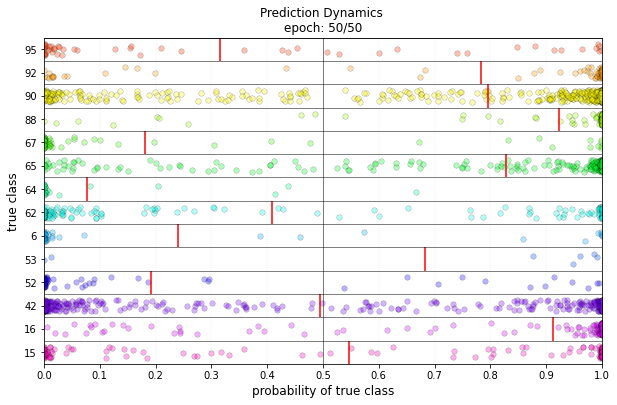

Total time              : 78.142091


78.142091

In [ ]:
X,y,splits = get_UCR_data('LSST', split_data=False)
tfms=[None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X,y,splits=splits,tfms=tfms, batch_tfms=batch_tfms)
learn = ts_learner(dls, InceptionTimePlus, metrics=[accuracy, BalancedAccuracy()], cbs=PredictionDynamics())
timer.start()
learn.fit_one_cycle(50, 1e-3)
timer.stop()

This callback adds some overhead to the training process, and thus it's a bit slower (in my experience just marginally).
In this case it's taken 78 seconds to train this model using this callback. Let's see how long does it take to train without the callback.

In [ ]:
learn = ts_learner(dls, InceptionTimePlus, metrics=[accuracy, BalancedAccuracy()])
timer.start()
learn.fit_one_cycle(50, 1e-3)
timer.stop()

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,2.467472,2.358184,0.325629,0.164527,00:01
1,2.102029,1.716008,0.543796,0.281223,00:01
2,1.738353,1.354078,0.611517,0.319294,00:01
3,1.445465,1.173358,0.658151,0.361624,00:01
4,1.234381,1.161743,0.625710,0.378895,00:01
5,1.081438,1.110411,0.649230,0.379578,00:01
6,0.962720,1.836739,0.459854,0.288023,00:01
7,0.873409,1.137848,0.623682,0.433010,00:01
8,0.825204,1.051876,0.656123,0.422945,00:01
9,0.766313,1.214325,0.603001,0.402398,00:01


Total time              : 56.166973


56.166973

56 seconds vs 72. In this case, training time took about 16s longer. 

In most cases I've used the extra time is approx .3 seconds per epoch. I'll leave it up to you to decide if it's worthwhile adding the callback.

## Callback parameters

There are a few callback parameters you may want to tweak (although the default ones will work in most cases): 
* show_perc:  percent of samples from the valid set that will be displayed. Default: 1 (all). You can reduce it if the number is too high and the chart is too busy.
* alpha:      level of transparency. Default:0.3. 1 means no transparency.
* figsize:    size of the chart. You may want to expand it if too many classes.
* size:       size of each sample in the chart. Default:30. You may need to decrease it a bit if too many classes/ samples.
* color:      color used in regression plots.
* cmap:       color map used in classification plots.

## Use with context managers:

Sometimes training time per epoch is very small, and it may be difficult to see the chart correctly. In that case you can use the context managers:

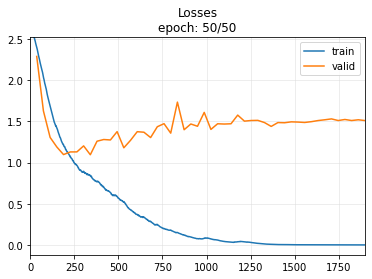

,train_loss,valid_loss,accuracy,balanced_accuracy_score
49,0.000824,1.50876,0.711679,0.551465


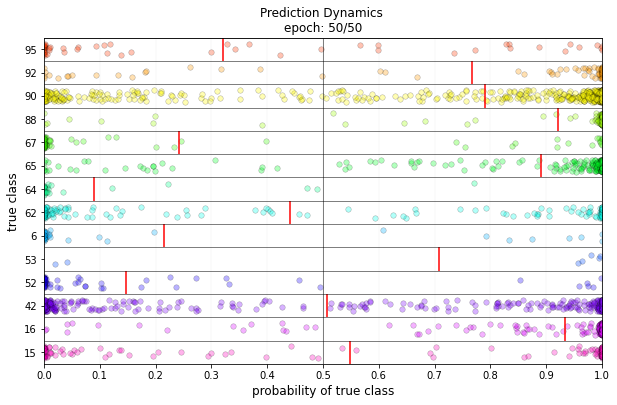

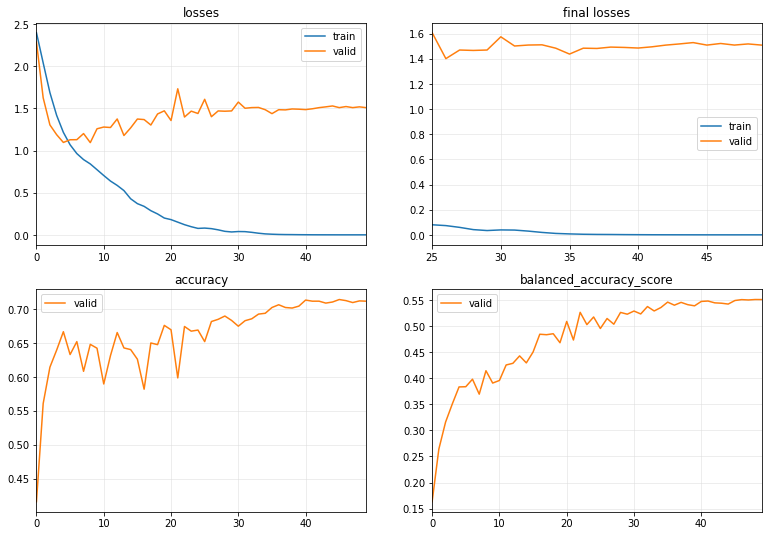

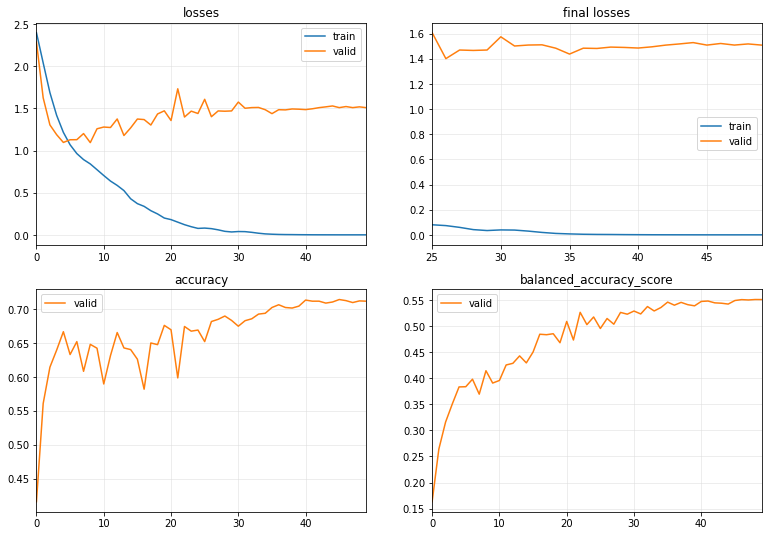

In [ ]:
X, y, splits = get_UCR_data('LSST', split_data=False)
tfms=[None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X,y,splits=splits,tfms=tfms, batch_tfms=batch_tfms)
learn = ts_learner(dls, InceptionTimePlus, metrics=[accuracy, BalancedAccuracy()], cbs=[ShowGraph(), PredictionDynamics()])
with ContextManagers([learn.no_logging()]): 
    learn.fit_one_cycle(50, 1e-3)
learn.plot_metrics()

# PredictionDynamics in regression tasks

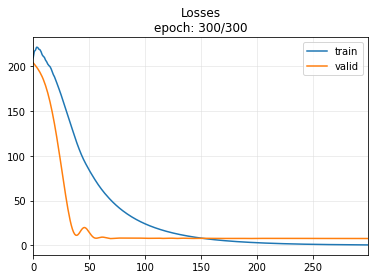

,train_loss,valid_loss,mae,_rmse
299,0.427422,7.589998,2.040455,2.754995


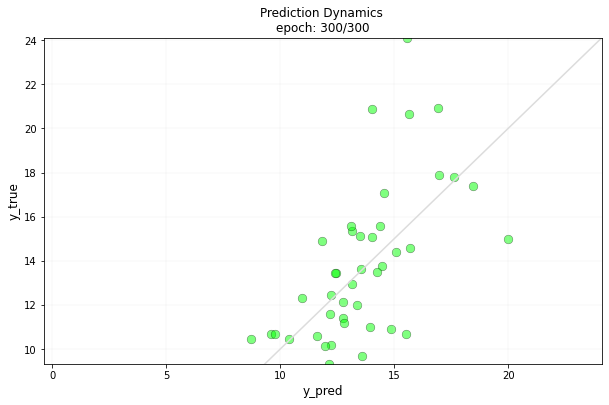

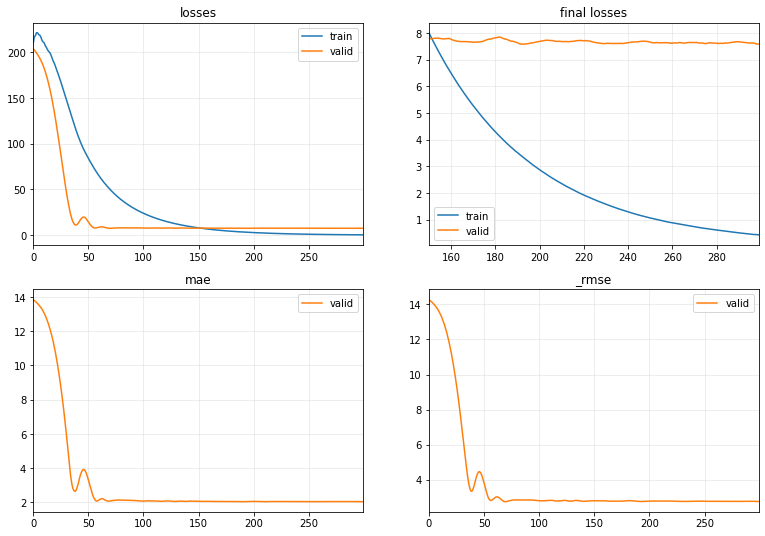

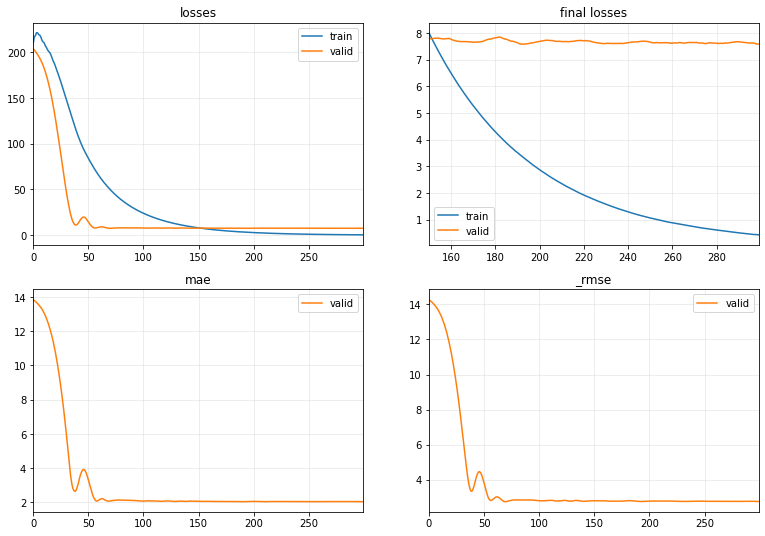

In [ ]:
X, y, splits = get_Monash_regression_data('AppliancesEnergy', split_data=False)
tfms=[None, TSRegression()]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X,y,splits=splits,tfms=tfms, batch_tfms=batch_tfms)
learn = ts_learner(dls, TSTPlus, metrics=[mae, rmse], cbs=[ShowGraph(), PredictionDynamics(alpha=.5, size=75)])
with ContextManagers([learn.no_logging()]): 
    learn.fit_one_cycle(300, 3e-4)
learn.plot_metrics()

# Conclusion

With this new addition there's something else to do while a model is training. You can get a better understanding of things like: 

* what are the easiest/ most difficult classes?
* is the model really focusing on the most frequent classes?
* how stable is training? how much change is there from epoch to epoch?
* how does the loss function impact predictions? (for example CrossEntropyLossFlat vs LabelSmoothingCrossEntropyFlat)
* how does adding class weights (in imbalanced datasets) change predictions?
and many more
....

I really encourage you to use PredictionDynamics with your own datasets and share your experience.
